# [PUBLIC] Analysis of CLBlast tuning

<a id="overview"></a>
## Overview

This Jupyter Notebook analyses the performance that CLBlast achieves across a range of routines, sizes and configurations.

<a id="data"></a>
## Get the experimental data from DropBox

**NB:** Please ignore this section if you are not interested in re-running or modifying this notebook. 

The experimental data was collected on the experimental platform and archived as follows:
```
$ cd `ck find ck-math:script:<...>`
$ python <...>.py
$ ck zip local:experiment:* --archive_name=<...>.zip
```

It can be downloaded and extracted as follows:
```
$ wget <...>.zip
$ ck add repo:<....> --zip=<....>.zip --quiet
```

<a id="code"></a>
## Data wrangling code

**NB:** Please ignore this section if you are not interested in re-running or modifying this notebook.

### Includes

#### Standard

In [1]:
import os
import sys
import json
import re

#### Scientific

If some of the scientific packages are missing, please install them using:
```
# pip install jupyter pandas numpy matplotlib
```

In [2]:
import IPython as ip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mp

In [3]:
print ('IPython version: %s' % ip.__version__)
print ('Pandas version: %s' % pd.__version__)
print ('NumPy version: %s' % np.__version__)
print ('Seaborn version: %s' % sns.__version__) # apt install python-tk
print ('Matplotlib version: %s' % mp.__version__)

IPython version: 5.3.0
Pandas version: 0.19.2
NumPy version: 1.12.0
Seaborn version: 0.7.1
Matplotlib version: 2.0.0


In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [5]:
from IPython.display import Image
from IPython.core.display import HTML

#### Collective Knowledge

If CK is not installed, please install it using:
```
# pip install ck
```

In [6]:
import ck.kernel as ck
print ('CK version: %s' % ck.__version__)

CK version: 1.8.7


### Define helper functions

In [7]:
# Return the number of floating-point operations for C = alpha * A * B + beta * C,
# where A is a MxK matrix and B is a KxN matrix.
def xgemm_flops(alpha, beta, M, K, N):
    flops_AB = 2*M*N*K if alpha!=0 else 0
    flops_C = 2*M*N if beta!=0 else 0
    flops = flops_AB + flops_C
    return flops

In [8]:
# Return GFLOPS (Giga floating-point operations per second) for a known kernel and -1 otherwise.
def GFLOPS(kernel, run_characteristics, time_ms):
    if kernel.lower().find('xgemm') != -1:
        time_ms = np.float64(time_ms)
        alpha = np.float64(run_characteristics['arg_alpha'])
        beta  = np.float64(run_characteristics['arg_beta'])
        M = np.int64(run_characteristics['arg_m'])
        K = np.int64(run_characteristics['arg_k'])
        N = np.int64(run_characteristics['arg_n'])
        return (1e-9 * xgemm_flops(alpha, beta, M, K, N)) / (1e-3 * time_ms)
    else:
        return (-1.0)

In [9]:
def args_str(kernel, run):
    args = ''
    if kernel.lower().find('xgemm') != -1:
        args = 'alpha=%s, beta=%s, M=%s, K=%s, N=%s' % \
            (run['arg_alpha'], run['arg_beta'], run['arg_m'], run['arg_k'], run['arg_n'])
    return args

### Access the experimental data

In [10]:
def get_experimental_results(repo_uoa='local', tags='explore-clblast-matrix-size'):
    module_uoa = 'experiment'
    r = ck.access({'action':'search', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'tags':tags})
    if r['return']>0:
        print ("Error: %s" % r['error'])
        exit(1)
    experiments = r['lst']
    
    dfs = []
    for experiment in experiments:
        data_uoa = experiment['data_uoa']
        r = ck.access({'action':'list_points', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'data_uoa':data_uoa})
        if r['return']>0:
            print ("Error: %s" % r['error'])
            exit(1)

        for point in r['points']:
            with open(os.path.join(r['path'], 'ckp-%s.0001.json' % point)) as point_file:
                point_data_raw = json.load(point_file)
                characteristics_list = point_data_raw['characteristics_list']
                num_repetitions = len(characteristics_list)
                # Obtain column data.
                data = [
                    {
                        'repetition_id': repetition_id,
                        'strategy'  : tuner_output['strategy'],
                        'config_id': config_id,
                        'config' : config['parameters'],
                        'kernel' : config['kernel'],
                        'args_id' : args_str(config['kernel'], characteristics['run']),
                        'ms' : np.float64(config['time']),
                        'GFLOPS' : GFLOPS(config['kernel'], characteristics['run'], config['time'])
                    }
                    for (repetition_id, characteristics) in zip(range(num_repetitions), characteristics_list) 
                    for tuner_output in characteristics['run']['data']
                    for (config_id, config) in zip(range(len(tuner_output['result'])), tuner_output['result'])
                ]
            # Construct a DataFrame.
            df = pd.DataFrame(data)
            # Set columns and index names.
            df.columns.name = 'characteristics'
            df.index.name = 'index'
            df = df.set_index([ 'kernel', 'strategy', 'args_id', 'config_id', 'repetition_id' ])
            # Append to the list of similarly constructed DataFrames.
            dfs.append(df)
    # Concatenate all constructed DataFrames (i.e. stack on top of each other).
    result = pd.concat(dfs)
    return result.sortlevel(result.index.names)

In [11]:
df = get_experimental_results(tags='explore-clblast-matrix-size,xgemm_direct-fp32')
pd.options.display.max_columns = len(df.columns)
pd.options.display.max_rows = len(df.index)

In [12]:
kernel0 = df.iloc[0].name[0]
kernel0

u'XgemmDirectTN'

In [13]:
# NB: Unlike mean(), mean() retains the 'config' column.
df_kernel0 = df.groupby(level=df.index.names[:-1]).min().loc[kernel0]
# df_kernel0

In [14]:
df_kernel0.groupby(level=df_kernel0.index.names[:-1])['GFLOPS'].min()

strategy    args_id                                     
exhaustive  alpha=2.00, beta=2.00, M=1024, K=128, N=1024    23.181886
            alpha=2.00, beta=2.00, M=128, K=1024, N=128     21.571741
            alpha=2.00, beta=2.00, M=256, K=256, N=512      22.323064
            alpha=2.00, beta=2.00, M=512, K=128, N=256      14.741315
random      alpha=2.00, beta=2.00, M=1024, K=128, N=1024     5.552234
            alpha=2.00, beta=2.00, M=128, K=1024, N=128      4.224274
            alpha=2.00, beta=2.00, M=256, K=256, N=512       5.407417
            alpha=2.00, beta=2.00, M=512, K=128, N=256       4.862896
Name: GFLOPS, dtype: float64

In [15]:
df_kernel0.groupby(level=df_kernel0.index.names[:-1])['GFLOPS'].max()

strategy    args_id                                     
exhaustive  alpha=2.00, beta=2.00, M=1024, K=128, N=1024    105.553105
            alpha=2.00, beta=2.00, M=128, K=1024, N=128      80.544844
            alpha=2.00, beta=2.00, M=256, K=256, N=512       98.639836
            alpha=2.00, beta=2.00, M=512, K=128, N=256       91.149801
random      alpha=2.00, beta=2.00, M=1024, K=128, N=1024     57.917493
            alpha=2.00, beta=2.00, M=128, K=1024, N=128      51.912210
            alpha=2.00, beta=2.00, M=256, K=256, N=512       56.519302
            alpha=2.00, beta=2.00, M=512, K=128, N=256       60.064966
Name: GFLOPS, dtype: float64

In [16]:
max_GFLOPS = df_kernel0.loc[df_kernel0['GFLOPS'].argmax()]['GFLOPS']
max_GFLOPS

105.55310495513071

In [17]:
max_GLOPS_config = df_kernel0.loc[df_kernel0['GFLOPS'].argmax()]['config']
max_GLOPS_config

{u'KWID': 2,
 u'MDIMAD': 8,
 u'MDIMCD': 8,
 u'NDIMBD': 16,
 u'NDIMCD': 16,
 u'PADA': 1,
 u'PADB': 1,
 u'PRECISION': 32,
 u'VWMD': 4,
 u'VWND': 2,
 u'WGD': 32}

#### Plot a violin graph

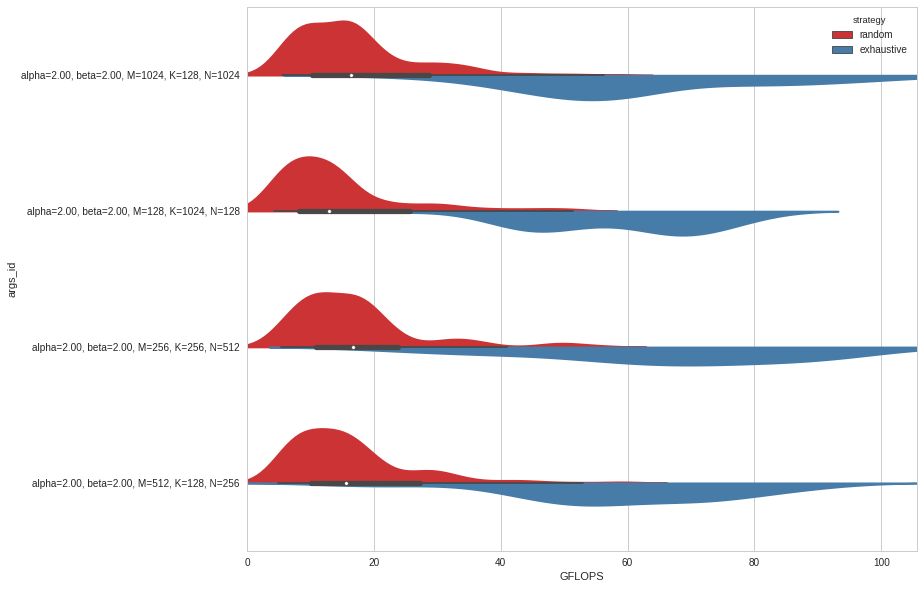

In [18]:
plt.figure(figsize=(12, 10))
sns.set_style('whitegrid'); sns.set_palette('Set1')
ax = sns.violinplot(data=df_kernel0.reset_index(), x='GFLOPS', y='args_id',
                    split=True, hue='strategy', hue_order=['random', 'exhaustive'])
ax.set_xticks(range(0, int(max_GFLOPS), 20))
ax.set_xlim([0, max_GFLOPS])
# Draw a dotted purple line from top to bottom at the default value (TODO).
ax.vlines(linestyles='dotted', colors='purple', x=124, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1])